# Ablatross Tracking Data - ETL and Visualisation

Fisheries New Zealand and the Department of Conservation tracked 75 Antipodean and Gibson's wandering albatross (starting January 2019) in real time. In addition to these, data from 14 Salvin's albatross (with data starting from October 2018) are also available.

Daily locational data from GPS and Argos transmitters were uploaded to a series of dedicated satellites, before being downloaded to a wildlife tracking service in France.

https://catalogue.data.govt.nz/dataset/albatross-tracking-data

This notebook and scripts make use of Python, Postgres, SQLAlchemy, QGIS and CV2 to generate a temporal animation, showing the flight paths of the 88 birds.


[![Embedding a YouTube Video](https://img.youtube.com/vi/OBuCILn5W2c/0.jpg)](https://www.youtube.com/watch?v=OBuCILn5W2c)

<sup>Video: Animated Flight Paths of 88 Albatross Birds</sup>



## Overview of Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import seaborn as sns

path = 'data/all_albatross_data_2019-09-23.csv'
albatross_data = pd.read_csv(path, sep=',', header=0)

In [14]:
albatross_data.columns

Index(['Identifier', 'Meta', 'DateTime', 'Long', 'Lat', 'LocQual', 'Date',
       'Time', 'mergeID', 'insertID', 'pDist', 'pTime', 'speed', 'Species',
       'Status', 'Sex', 'DoCID', 'TagType'],
      dtype='object')

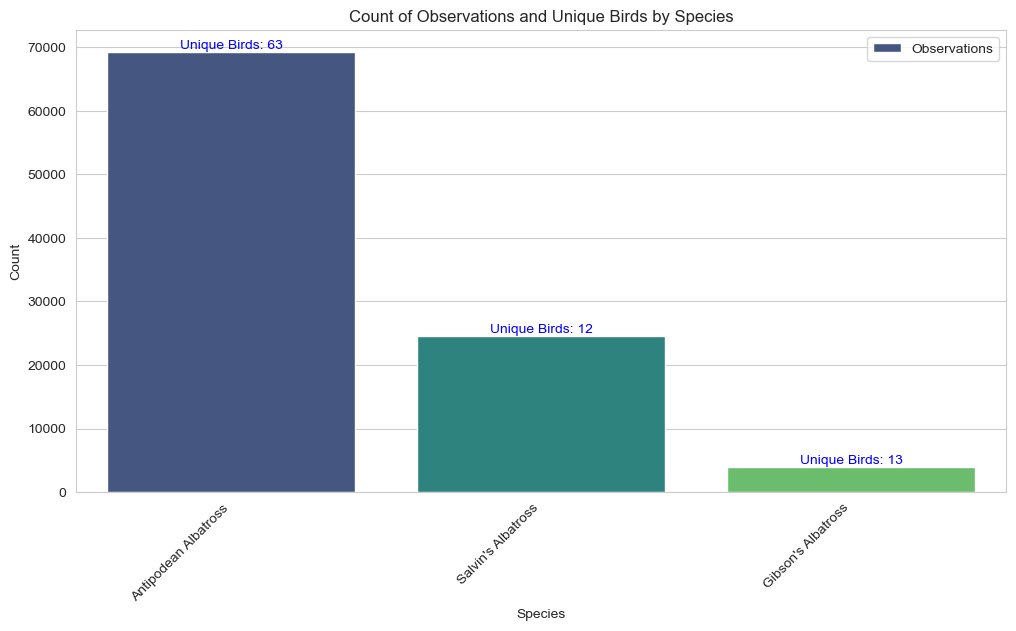

In [75]:
# Count of observations by species
species_counts = albatross_data['Species'].value_counts()

# Count of unique birds by species
unique_bird_counts = albatross_data.groupby('Species')['Identifier'].nunique()

# Visualize count of observations by species
plt.figure(figsize=(12, 6))
sns.barplot(x=species_counts.index, y=species_counts.values, palette='viridis', label='Observations')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Species')
plt.ylabel('Count')
plt.title('Count of Observations and Unique Birds by Species')

# Add annotations for unique bird counts
for i, count in enumerate(unique_bird_counts):
    plt.text(i, species_counts.values[i] + 10, f'Unique Birds: {count}', ha='center', va='bottom', fontsize=10, color='blue')

plt.legend()
plt.show()


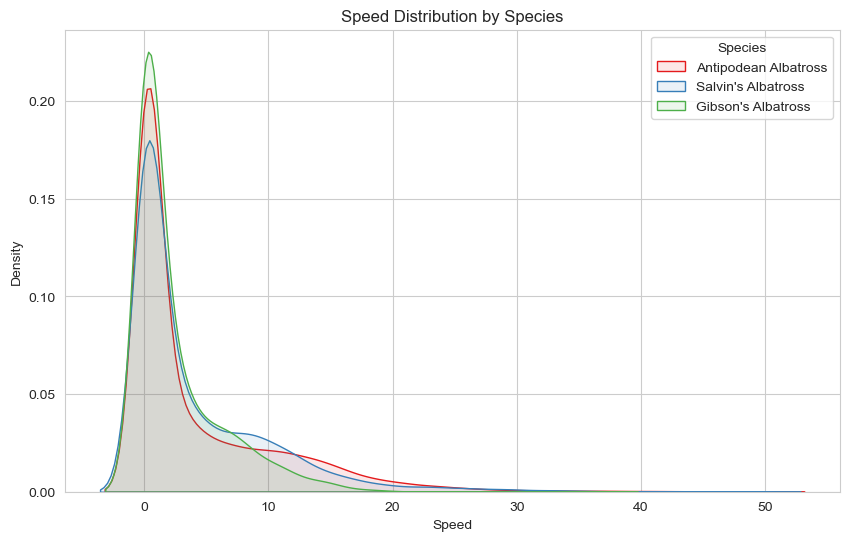

In [64]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Set a color palette with different colors for each species
palette = sns.color_palette("Set1", n_colors=len(albatross_data['Species'].unique()))

# Create distribution lines for each species with reduced shading
for species, color in zip(albatross_data['Species'].unique(), palette):
    sns.kdeplot(
        albatross_data[albatross_data['Species'] == species]['speed'],
        color=color,
        label=species,
        shade=True,  # Enable shading
        alpha=0.1,  # Adjust the alpha to reduce shading
        bw_adjust=1.5,  # Adjust the smoothness of the curve
    )

ax.set_xlabel('Speed')
ax.set_ylabel('Density')
ax.set_title('Speed Distribution by Species')
ax.legend(title='Species', loc='upper right')

# Show the plot
plt.show()


## Visualing the Data Points

In [5]:
# use a random sample of 1000
data = albatross_data.sample(n=1000, random_state=1)

In [7]:
import ipywidgets as widgets
from ipywidgets import Layout
from ipyleaflet import Map, basemaps, CircleMarker
import matplotlib.cm as cm
from matplotlib.colors import Normalize, to_hex

# Get unique 'Identifier' values
unique_identifiers = data['Identifier'].unique()

# Create a Viridis colormap
cmap = cm.viridis

# Normalize 'Identifier' values to map them to the colormap
norm = Normalize(vmin=0, vmax=len(unique_identifiers))

# Create a dictionary to map 'Identifier' to colors along Viridis
colors_dict = {identifier: to_hex(cmap(norm(i))) for i, identifier in enumerate(unique_identifiers)}

# Create a map
m = Map(center=(data['Lat'].mean(), data['Long'].mean()), zoom=4, layout=Layout(width='800px', height='800px'))

# Add a basemap
m.add_layer(basemaps.CartoDB.Positron)

# Add CircleMarkers for each data point with colors along Viridis
for index, row in data.iterrows():
    circle_marker = CircleMarker(
        location=(row['Lat'], row['Long']),
        radius=5,
        color=colors_dict[row['Identifier']],
        fill_color=colors_dict[row['Identifier']],
        fill_opacity=0.7,
        stroke=False
    )
    m.add_layer(circle_marker)

# Display the map
m

Map(center=[-43.356623941799995, 193.48843093480002], controls=(ZoomControl(options=['position', 'zoom_in_text…

## Import in PostGres Database

To analyse and generate further visualisations, we import the data into a local PostGres Database using Psycopg and GeoAlchemy. GeoAlchemy is an extension of SQLAlchemy. It provides support for Geospatial data types at the ORM layer using SQLAlchemy. It will allows us to transform and load the Latitudinal and Longditudal as Shapely Point geometries without a WKT (well-known text) encoder.

In [ ]:
import psycopg2

conn = psycopg2.connect(database="postgres",
                        host="localhost",
                        user="postgres",
                        password="admin",
                        port="5432")

cursor = conn.cursor()

In [ ]:
import pandas as pd
from sqlalchemy import create_engine, types
from shapely.geometry import Point
from geoalchemy2 import Geometry, WKTElement
import geopandas as gpd  # For GeoDataFrame support

# Convert 'DateTime' column to the expected format (e.g., 'YYYY-MM-DD HH:MM:SS')
albatross_data['DateTime'] = pd.to_datetime(albatross_data['DateTime'], format='%d/%m/%Y %H:%M')

# convert Date column to the expected format (e.g., 'YYYY-MM-DD')
albatross_data['Date'] = pd.to_datetime(albatross_data['Date'], format='%d/%m/%Y')

# convert Time column to the expected format (e.g., 'HH:MM:SS')
albatross_data['Time'] = pd.to_datetime(albatross_data['Time'], format='%H:%M:%S')

# Define data types for each column in the DataFrame
column_data_types = {
    'Identifier': types.String(255),
    'Meta': types.String(255),
    'DateTime': types.TIMESTAMP(),
    'Long': types.Float,
    'Lat': types.Float,
    'LocQual': types.String(255),
    'Date': types.DATE,
    'Time': types.TIME,
    'mergeID': types.String(255),
    'insertID': types.String(255),
    'pDist': types.Float,
    'pTime': types.Integer,
    'speed': types.Float,
    'Species': types.String(255),
    'Status': types.String(255),
    'Sex': types.String(255),
    'DoCID': types.String(255),
    'TagType': types.String(255),
}

# Convert latitude and longitude to a geometry column
albatross_data['geometry'] = albatross_data.apply(lambda x: Point(float(x.Long), float(x.Lat)), axis=1)

# Make it into a GeoDataFrame. Use 3832 as the data covers the Pacific Ocean.
albatross_data = gpd.GeoDataFrame(albatross_data, geometry='geometry', crs='EPSG:4326')

# Define the database connection details as a dictionary
db_config = {
    'database': 'postgres',
    'host': 'localhost',
    'user': 'postgres',
    'password': 'admin',
    'port': '5432'
}

# Create a SQLAlchemy engine and connect to your PostgreSQL database
engine = create_engine(f'postgresql://{db_config["user"]}:{db_config["password"]}@{db_config["host"]}:{db_config["port"]}/{db_config["database"]}')

# Specify the name of the table in PostgreSQL
table_name = 'albatross_data'

# Use the to_sql method to create the table and insert the data from the DataFrame
albatross_data.to_postgis(
    table_name,
    engine,
    if_exists='replace',
    index=False,
    dtype=column_data_types  # Add column data types
)


## Connect to PostGres Database in QGIS 

`Layer > Add Layer > Add PostGIS Layer`

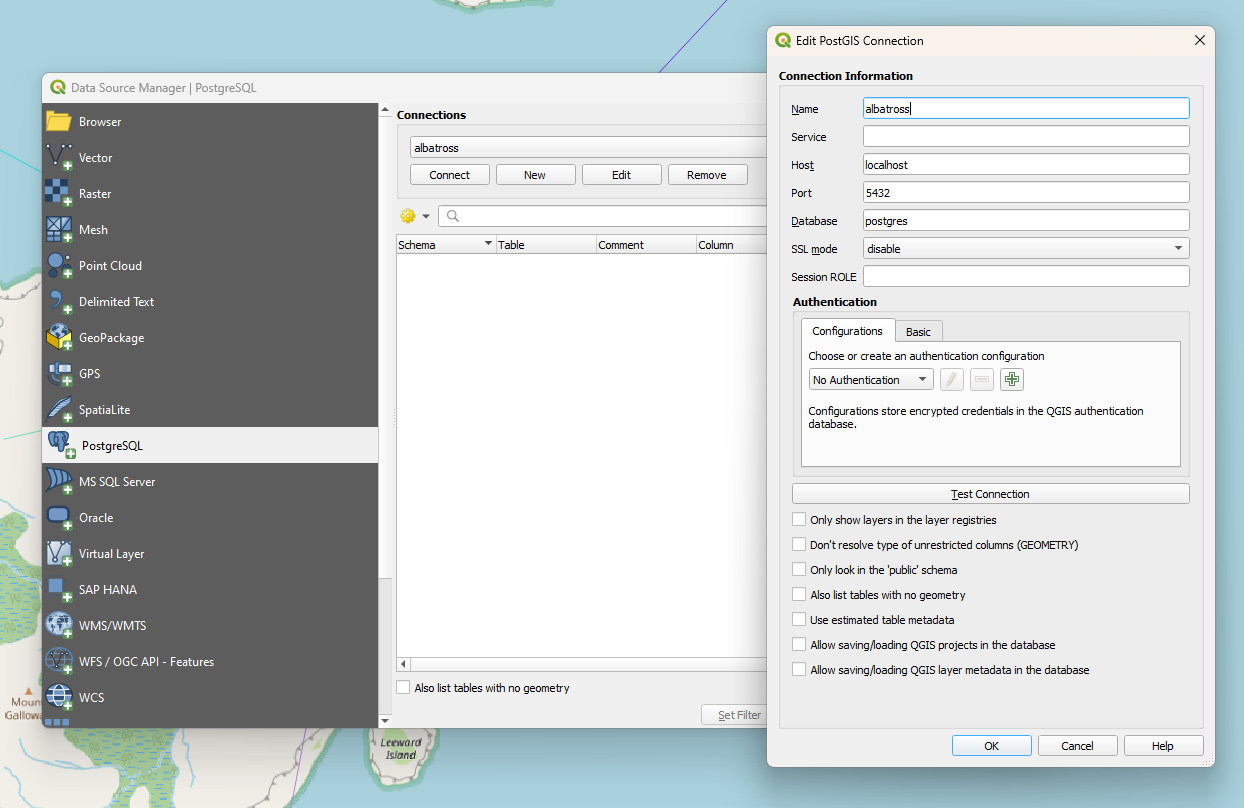

## Generate Tracking Lines from Point Data

In order to effectively animate the movement of birds we first need to turn our Point data into line data, ensuring that the 'start' and 'end' datetime variable for each line segment corresponds to the DateTime variable of each pair of consequitive points, for each individual Bird 'Indetifier'.

As far as I could tell, QGIS did NOT have in-built functionality to generate a Path from Points whilst maintaining the temporal data for each individual line segment AND grouping by each bird.

I created a Python script that has this functionality, generating temporal line segments for each bird's path from the original Point data.

## Temporal Path Script

To use this script, run within the QGIS python editor.

In [ ]:
# Import necessary QGIS modules
from qgis.core import QgsProject, QgsVectorLayer, QgsFeature, QgsGeometry, QgsField
from PyQt5.QtCore import QVariant

# Define the input point layer name
input_layer_name = "reprojected"  # Replace with your actual layer name

# Load the input point layer
input_layer = QgsProject.instance().mapLayersByName(input_layer_name)[0]

# Check if the layer exists
if not input_layer.isValid():
    raise Exception(f"Layer '{input_layer_name}' not found in '{geopackage_path}'!")

# Create a new line layer to store the results
line_layer = QgsVectorLayer("LineString?crs=" + input_layer.crs().authid(), "bird_tracking_lines", "memory")

# Define fields for the line layer
fields = [
    QgsField("Identifier", QVariant.String),
    QgsField("Start_Time", QVariant.DateTime),
    QgsField("End_Time", QVariant.DateTime),
]

line_layer.dataProvider().addAttributes(fields)
line_layer.updateFields()

# Initialize a dictionary to store points for each bird
bird_points = {}

# Loop through features in the input layer
for feature in input_layer.getFeatures():
    bird_id = feature["Identifier"]
    datetime = feature["DateTime"]

    # Check if the bird_id is already in the dictionary
    if bird_id not in bird_points:
        bird_points[bird_id] = {"start_datetime": datetime, "end_datetime": datetime, "points": []}
    else:
        bird_points[bird_id]["end_datetime"] = datetime

    bird_points[bird_id]["points"].append((datetime, feature.geometry().asPoint()))

# Create line segments for each bird's path
lines = []
for bird_id, data in bird_points.items():
    if len(data["points"]) > 1:
        # Sort points by datetime
        sorted_points = sorted(data["points"], key=lambda x: x[0])
        
        # Create line segments
        for i in range(len(sorted_points) - 1):
            start_time = sorted_points[i][0]
            end_time = sorted_points[i+1][0]
            line = QgsGeometry.fromPolyline([QgsPoint(sorted_points[i][1]), QgsPoint(sorted_points[i+1][1])])
            feature = QgsFeature()
            feature.setGeometry(line)
            feature.setAttributes([bird_id, start_time, end_time])
            lines.append(feature)

# Add line features to the line layer
line_layer.dataProvider().addFeatures(lines)

# Add the line layer to the map
QgsProject.instance().addMapLayer(line_layer)

# Refresh the QGIS interface
iface.mapCanvas().refresh()

## Output

Below is the output from the custom Points to Path script, showing the complete movement of the 88 birds, Coloured randomly by 'Identifier' with Google Sattelite XYZ layer used as a Basemap.

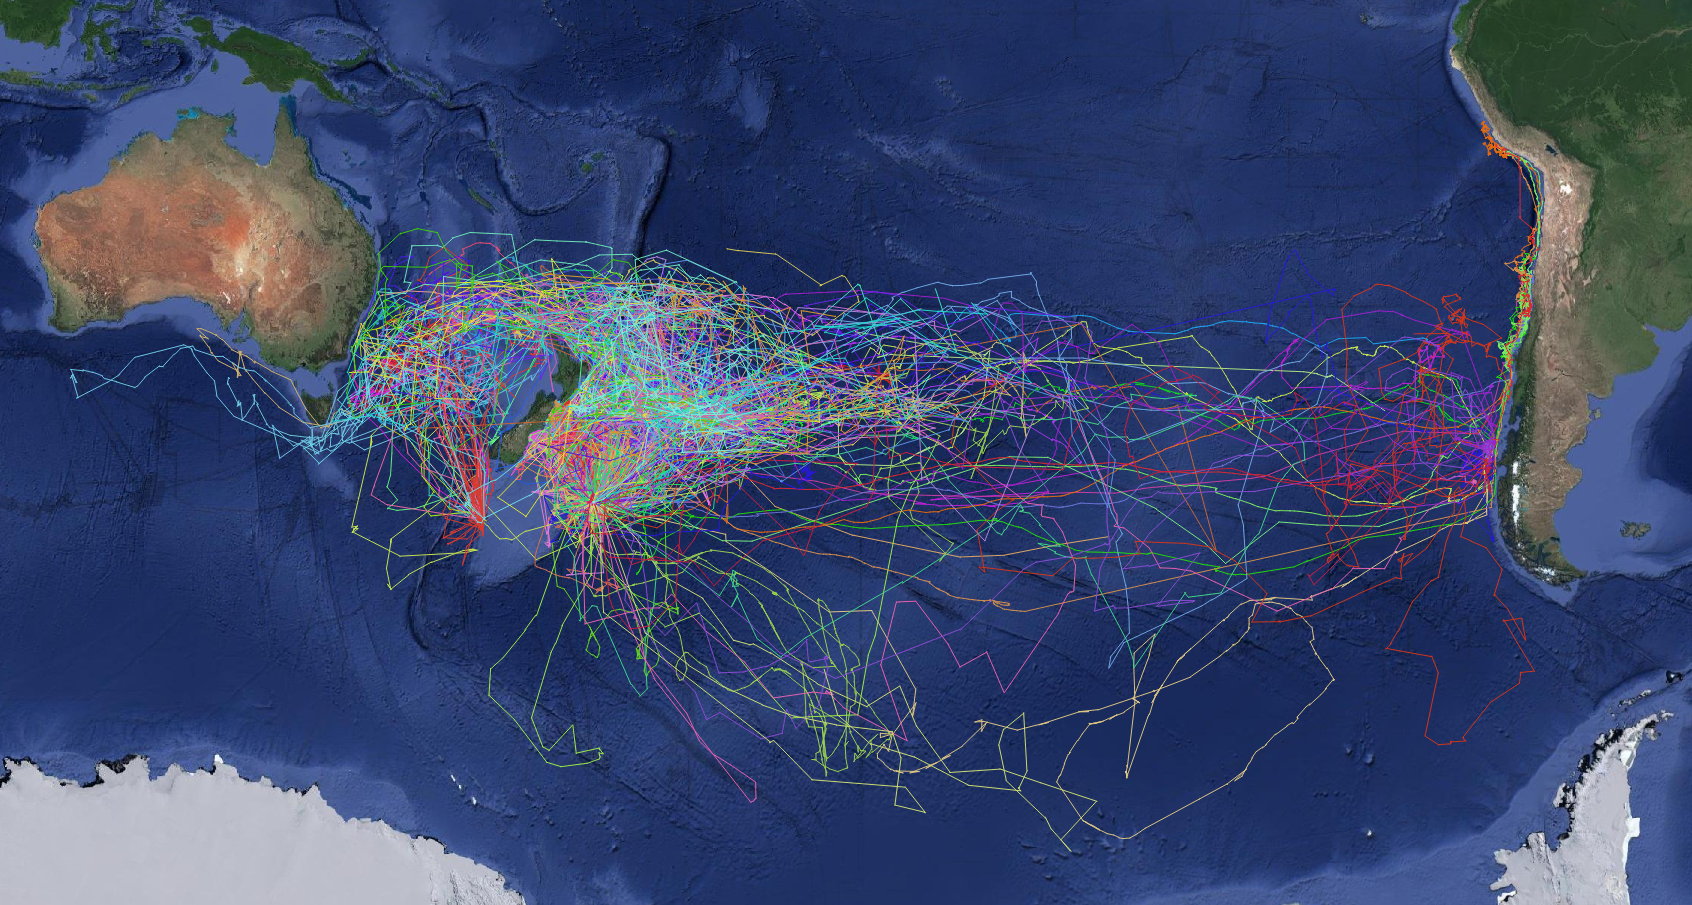

### Symbology

Here is the symbology used to distinguish each bird.

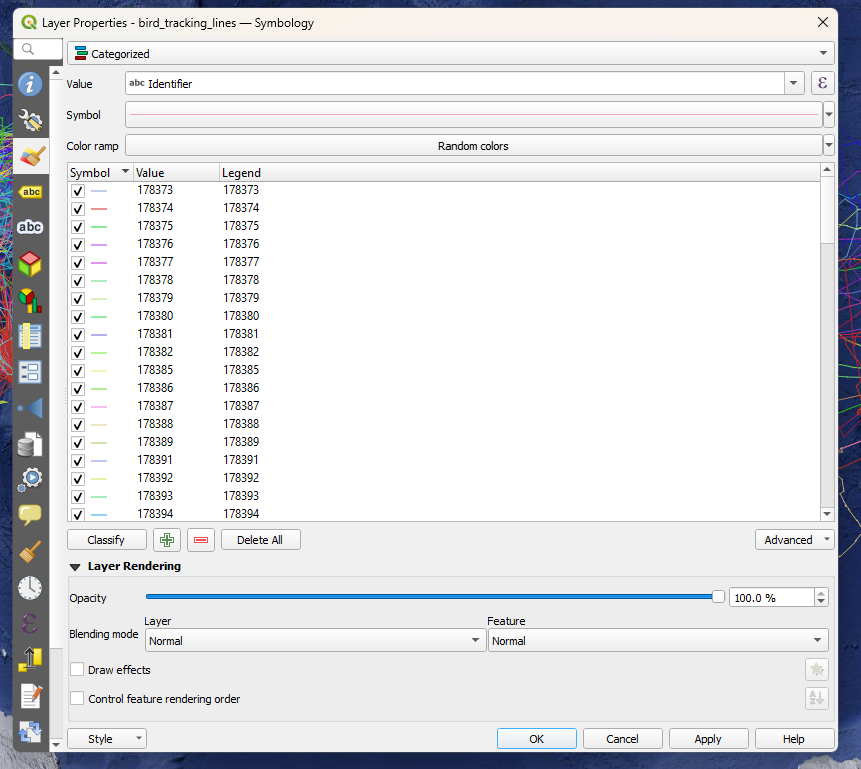

## Generating Temporal Animation

Using the `Time Manager` plugin, we are able to create a temporal animation of each birds movements. This was possibly because each sub-section of the paths contains the original DateTime data from the points. Selecting a frame time of 12 hours gives us a reasonable balance between granularity and the number of PNG's in our output.

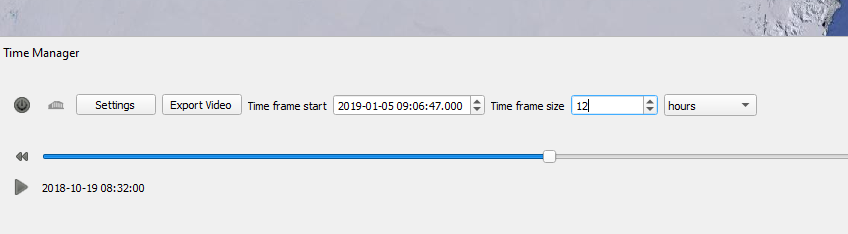

 - *Make sure you select 'Accumulate Features' in settings*

 #### Output Images

 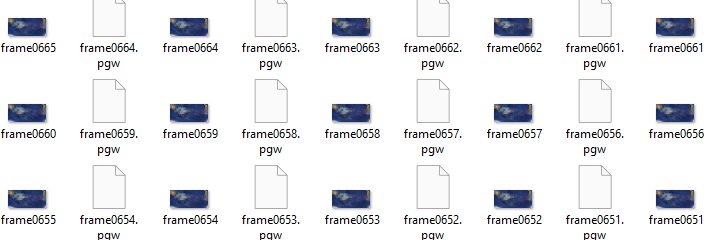

## Create a Video from the Image Sequence

QGIS `TimeManager` does not support the direct output of a MP4 file. We use CV2 to generate our video from the output images.

In [4]:
import cv2
import os

# Directory containing the PNG images
png_dir = 'C:/Users/hamis/Videos/aqa' # Replace with your actual PNG directory

# Define the output video file
output_video_path = 'C:/Users/hamis/Videos/aqa/output.mp4' # Replace with your actual output file

# Set the frames per second (FPS) and frame size (width, height)
fps = 30  # Adjust this as needed
frame_size = (1920, 1080)  # Adjust this to match your image size

# Create a VideoWriter object to save the video
fourcc = cv2.VideoWriter_fourcc(*'XVID')  # Use XVID codec
out = cv2.VideoWriter(output_video_path, fourcc, fps, frame_size)

# List all PNG files in the directory
png_files = [f for f in os.listdir(png_dir) if f.endswith('.png')]

# Sort the files to ensure they are in the correct order
png_files.sort()

for png_file in png_files:
    image_path = os.path.join(png_dir, png_file)
    frame = cv2.imread(image_path)
    
    # Ensure the frame size matches the specified size
    frame = cv2.resize(frame, frame_size)
    
    out.write(frame)

# Release the VideoWriter
out.release()

print(f"Video saved to {output_video_path}")


Video saved to C:/Users/hamis/Videos/aqa/output.mp4
